# TCT Path_finder vs Custom 2-hop Query Comparison

This notebook systematically compares two approaches for finding Gene → Intermediate → Disease paths:

1. **Custom 2-hop Query** (BioGraph Explorer approach): 
   - Single TRAPI query with 3 nodes (Gene → Intermediate → Disease) and 2 edges
   - All genes queried together in one batch
   - Returns raw edges from APIs

2. **TCT.Path_finder()** (TCT library approach):
   - Calls `TCT.Path_finder(gene, disease, intermediate_categories, ...)` for each gene
   - Internally uses two 1-hop queries and merges overlapping intermediates
   - Returns ranked paths

**Focus**: Result coverage - which approach finds more intermediate nodes?

**Test Dataset**: COVID-19 genes (CD6, IFITM3, IFITM2, STAT5A, KLRG1, DPP4, IL32, PIK3AP1, FYN, IL4R)

## 1. Setup & Imports

In [1]:
import json
import time
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Any, Set, Tuple
from datetime import datetime
from pathlib import Path

# TCT imports
try:
    from TCT import TCT
    from TCT import name_resolver
    from TCT import translator_metakg
    from TCT import translator_kpinfo
    from TCT import translator_query
    TCT_AVAILABLE = True
    print("✓ TCT library loaded successfully")
except ImportError as e:
    print(f"⚠️  TCT not installed. Run: pip install TCT")
    print(f"   Error: {e}")
    TCT_AVAILABLE = False

# Configuration
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)
(DATA_DIR / "comparison").mkdir(exist_ok=True)

print(f"\n✓ Setup complete")
print(f"  TCT available: {TCT_AVAILABLE}")

✓ TCT library loaded successfully

✓ Setup complete
  TCT available: True


In [2]:
# Load Translator resources
if TCT_AVAILABLE:
    print("Loading Translator resources...")
    print("(This may take 1-2 minutes and some APIs may timeout - this is normal)\n")
    
    try:
        APInames, metaKG, Translator_KP_info = translator_metakg.load_translator_resources()
        
        print(f"\n✓ Successfully loaded resources:")
        print(f"  APIs: {len(APInames)}")
        print(f"  MetaKG edges: {len(metaKG)}")
        
    except Exception as e:
        print(f"\n⚠️  Error during resource loading: {e}")
        print("\nAttempting fallback: loading without Plover APIs...")
        
        Translator_KP_info, APInames = translator_kpinfo.get_translator_kp_info()
        metaKG = translator_metakg.get_KP_metadata(APInames)
        
        print(f"\n✓ Loaded resources (fallback mode):")
        print(f"  APIs: {len(APInames)}")
        print(f"  MetaKG edges: {len(metaKG)}")
    
    # Build API predicates dictionary
    API_predicates = {}
    API_withMetaKG = list(set(metaKG['API']))
    for api in API_withMetaKG:
        API_predicates[api] = list(set(metaKG[metaKG['API'] == api]['Predicate']))
    
    print(f"\n✓ API predicates built for {len(API_predicates)} APIs")
else:
    print("⚠️  TCT not available - cannot load resources")

Loading Translator resources...
(This may take 1-2 minutes and some APIs may timeout - this is normal)


⚠️  Error during resource loading: Expecting value: line 1 column 1 (char 0)

Attempting fallback: loading without Plover APIs...

✓ Loaded resources (fallback mode):
  APIs: 58
  MetaKG edges: 12494

✓ API predicates built for 33 APIs


## 2. Gene Normalization

In [3]:
# COVID-19 differential expression genes
COVID_GENES = [
    "CD6",
    "IFITM3",
    "IFITM2",
    "STAT5A",
    "KLRG1",
    "DPP4",
    "IL32",
    "PIK3AP1",
    "FYN",
    "IL4R"
]

# Disease target
COVID19_CURIE = "MONDO:0100096"

# Intermediate categories for 2-hop queries
INTERMEDIATE_CATEGORIES = [
    'biolink:Protein',
    'biolink:Gene', 
    'biolink:ChemicalEntity'
]

if TCT_AVAILABLE:
    print(f"Normalizing {len(COVID_GENES)} genes using TCT name_resolver...")
    print("(Requesting human genes only: NCBITaxon:9606)\n")
    
    # Use human-only lookup for more reliable CURIEs
    results = []
    for gene_symbol in COVID_GENES:
        try:
            # Try human-specific lookup first
            info = name_resolver.lookup(gene_symbol, only_taxa='NCBITaxon:9606')
            if info and hasattr(info, 'curie') and info.curie:
                results.append({
                    'original': gene_symbol,
                    'curie': info.curie,
                })
                print(f"  ✓ {gene_symbol} → {info.curie}")
            else:
                # Fallback to batch lookup
                batch_result = name_resolver.batch_lookup([gene_symbol])
                if gene_symbol in batch_result:
                    info = batch_result[gene_symbol]
                    curie = info.curie if hasattr(info, 'curie') else None
                    results.append({'original': gene_symbol, 'curie': curie})
                    print(f"  ✓ {gene_symbol} → {curie} (batch fallback)")
                else:
                    print(f"  ✗ {gene_symbol} - not found")
                    results.append({'original': gene_symbol, 'curie': None})
        except Exception as e:
            # Try batch lookup as fallback
            try:
                batch_result = name_resolver.batch_lookup([gene_symbol])
                if gene_symbol in batch_result:
                    info = batch_result[gene_symbol]
                    curie = info.curie if hasattr(info, 'curie') else None
                    results.append({'original': gene_symbol, 'curie': curie})
                    print(f"  ✓ {gene_symbol} → {curie} (batch fallback)")
                else:
                    print(f"  ✗ {gene_symbol} - not found")
                    results.append({'original': gene_symbol, 'curie': None})
            except:
                print(f"  ✗ {gene_symbol} - error: {str(e)[:40]}")
                results.append({'original': gene_symbol, 'curie': None})
    
    normalized_genes_df = pd.DataFrame(results)
    normalized_genes_df = normalized_genes_df[normalized_genes_df['curie'].notna()]
    
    input_gene_curies = normalized_genes_df['curie'].tolist()
    
    print(f"\n✓ Successfully normalized {len(input_gene_curies)}/{len(COVID_GENES)} genes")
    display(normalized_genes_df)
else:
    print("⚠️  TCT not available")
    input_gene_curies = []

Normalizing 10 genes using TCT name_resolver...
(Requesting human genes only: NCBITaxon:9606)

  ✓ CD6 → NCBIGene:923
  ✓ IFITM3 → NCBIGene:10410
  ✓ IFITM2 → NCBIGene:10581
  ✓ STAT5A → NCBIGene:6776
  ✓ KLRG1 → NCBIGene:10219
  ✓ DPP4 → NCBIGene:1803
  ✓ IL32 → NCBIGene:9235
  ✓ PIK3AP1 → NCBIGene:118788
  ✓ FYN → NCBIGene:2534
  ✓ IL4R → NCBIGene:3566

✓ Successfully normalized 10/10 genes


,original,curie
0,CD6,NCBIGene:923
1,IFITM3,NCBIGene:10410
2,IFITM2,NCBIGene:10581
3,STAT5A,NCBIGene:6776
4,KLRG1,NCBIGene:10219
5,DPP4,NCBIGene:1803
6,IL32,NCBIGene:9235
7,PIK3AP1,NCBIGene:118788
8,FYN,NCBIGene:2534
9,IL4R,NCBIGene:3566


## 3. Approach 1: Custom 2-hop Query

Single TRAPI query with structure: Gene → [Intermediate] → Disease

This is the approach used by BioGraph Explorer's `TRAPIClient`.

In [4]:
if not TCT_AVAILABLE or len(input_gene_curies) == 0:
    print("⚠️  Skipping - TCT not available or no genes normalized")
    approach1_results = {}
    approach1_apis_success = []
    approach1_apis_failed = []
else:
    print("=" * 60)
    print("APPROACH 1: Custom 2-hop Query")
    print("=" * 60)
    print(f"\nQuery structure: Gene → [Intermediate] → Disease")
    print(f"  Input genes: {len(input_gene_curies)}")
    print(f"  Intermediate categories: {', '.join([c.replace('biolink:', '') for c in INTERMEDIATE_CATEGORIES])}")
    print(f"  Target disease: {COVID19_CURIE}")
    
    # Get predicates for each hop
    hop1_predicates = list(set(
        TCT.select_concept(
            sub_list=['biolink:Gene'],
            obj_list=INTERMEDIATE_CATEGORIES,
            metaKG=metaKG
        )
    ))
    
    hop2_predicates = list(set(
        TCT.select_concept(
            sub_list=INTERMEDIATE_CATEGORIES,
            obj_list=['biolink:Disease'],
            metaKG=metaKG
        )
    ))
    
    print(f"\n✓ Predicate discovery:")
    print(f"  Hop 1 (gene→intermediate): {len(hop1_predicates)} predicates")
    print(f"  Hop 2 (intermediate→disease): {len(hop2_predicates)} predicates")
    
    # Build custom 2-hop query
    query_2hop = {
        'message': {
            'query_graph': {
                'nodes': {
                    'n00': {
                        'ids': input_gene_curies,
                        'categories': ['biolink:Gene']
                    },
                    'n01': {
                        'categories': INTERMEDIATE_CATEGORIES  # No IDs
                    },
                    'n02': {
                        'ids': [COVID19_CURIE],
                        'categories': ['biolink:Disease']
                    }
                },
                'edges': {
                    'e00': {
                        'subject': 'n00',
                        'object': 'n01',
                        'predicates': hop1_predicates
                    },
                    'e01': {
                        'subject': 'n01',
                        'object': 'n02',
                        'predicates': hop2_predicates
                    }
                }
            }
        }
    }
    
    # Select APIs based on hop1 (gene→intermediate)
    selected_APIs_2hop = TCT.select_API(
        sub_list=['biolink:Gene'],
        obj_list=INTERMEDIATE_CATEGORIES,
        metaKG=metaKG
    )
    
    print(f"\n✓ Selected {len(selected_APIs_2hop)} APIs for 2-hop query")
    
    # Execute query
    print(f"\nQuerying APIs in parallel...")
    print("⏳ This may take 1-2 minutes.\n")
    
    start_time = time.time()
    
    approach1_results = translator_query.parallel_api_query(
        query_json=query_2hop,
        select_APIs=selected_APIs_2hop,
        APInames=APInames,
        API_predicates=API_predicates,
        max_workers=min(5, len(selected_APIs_2hop))
    )
    
    approach1_time = time.time() - start_time
    
    # Track API success/failure (based on whether results were returned)
    approach1_apis_success = []
    approach1_apis_failed = list(selected_APIs_2hop)  # Start with all as failed, remove successes
    
    print(f"\n{'=' * 60}")
    print(f"APPROACH 1 RESULTS")
    print(f"{'=' * 60}")
    print(f"Edges found: {len(approach1_results)}")
    print(f"Execution time: {approach1_time:.1f}s")
    print(f"APIs queried: {len(selected_APIs_2hop)}")

APPROACH 1: Custom 2-hop Query

Query structure: Gene → [Intermediate] → Disease
  Input genes: 10
  Intermediate categories: Protein, Gene, ChemicalEntity
  Target disease: MONDO:0100096

✓ Predicate discovery:
  Hop 1 (gene→intermediate): 56 predicates
  Hop 2 (intermediate→disease): 47 predicates

✓ Selected 17 APIs for 2-hop query

Querying APIs in parallel...
⏳ This may take 1-2 minutes.

Automat-robokop(Trapi v1.5.0): Success!

APPROACH 1 RESULTS
Edges found: 1575
Execution time: 301.0s
APIs queried: 17


## 4. Approach 2: TCT.Path_finder() Direct Usage

TCT's `Path_finder` function finds paths between two nodes with intermediate categories.

**Signature:**
```python
TCT.Path_finder(input_node1, input_node2, intermediate_categories, APInames, metaKG, API_predicates,
                input_node1_category=[], input_node2_category=[])
```

Since Path_finder takes two individual nodes, we'll call it for each gene → disease pair and aggregate the results.

APPROACH 2: TCT.Path_finder() Direct Usage

Calling Path_finder for each gene → disease pair:
  Genes: 10
  Disease: MONDO:0100096
  Intermediate categories: Protein, Gene, ChemicalEntity

  [1/10] CD6 (NCBIGene:923) → MONDO:0100096
UNII:PZS19MI6TT
NCBIGene:100643845
Number of possible paths:  0
       - No paths in result tuple

  [2/10] IFITM3 (NCBIGene:10410) → MONDO:0100096


/Users/nelphick/Library/Caches/pypoetry/virtualenvs/biograph-explorer-j0RCrEaw-py3.11/lib/python3.11/site-packages/TCT/TCT.py:1546: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center", fontsize=fontsize)


NCBIGene:13203075
NCBIGene:100643845
Number of possible paths:  0
       - No paths in result tuple

  [3/10] IFITM2 (NCBIGene:10581) → MONDO:0100096


/Users/nelphick/Library/Caches/pypoetry/virtualenvs/biograph-explorer-j0RCrEaw-py3.11/lib/python3.11/site-packages/TCT/TCT.py:1546: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center", fontsize=fontsize)


PUBCHEM.COMPOUND:44457280
NCBIGene:100643845
Automat-pharos(Trapi v1.5.0): Success!
Automat-robokop(Trapi v1.5.0): Success!
BioThings Explorer (BTE) TRAPI: Success!
Service Provider TRAPI: Success!
Number of possible paths:  0
       ✓ Found 2 paths

  [4/10] STAT5A (NCBIGene:6776) → MONDO:0100096


/Users/nelphick/Library/Caches/pypoetry/virtualenvs/biograph-explorer-j0RCrEaw-py3.11/lib/python3.11/site-packages/TCT/TCT.py:1546: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center", fontsize=fontsize)


NCBIGene:13199514
NCBIGene:100643845
Number of possible paths:  0
       - No paths in result tuple

  [5/10] KLRG1 (NCBIGene:10219) → MONDO:0100096


/Users/nelphick/Library/Caches/pypoetry/virtualenvs/biograph-explorer-j0RCrEaw-py3.11/lib/python3.11/site-packages/TCT/TCT.py:1546: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center", fontsize=fontsize)


NCBIGene:13195419
NCBIGene:100643845
Number of possible paths:  0
       - No paths in result tuple

  [6/10] DPP4 (NCBIGene:1803) → MONDO:0100096


/Users/nelphick/Library/Caches/pypoetry/virtualenvs/biograph-explorer-j0RCrEaw-py3.11/lib/python3.11/site-packages/TCT/TCT.py:1546: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center", fontsize=fontsize)


NCBIGene:13208727
NCBIGene:100643845
Number of possible paths:  0
       - No paths in result tuple

  [7/10] IL32 (NCBIGene:9235) → MONDO:0100096


/Users/nelphick/Library/Caches/pypoetry/virtualenvs/biograph-explorer-j0RCrEaw-py3.11/lib/python3.11/site-packages/TCT/TCT.py:1546: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center", fontsize=fontsize)


NCBIGene:13201616
NCBIGene:100643845
Number of possible paths:  0
       - No paths in result tuple

  [8/10] PIK3AP1 (NCBIGene:118788) → MONDO:0100096


/Users/nelphick/Library/Caches/pypoetry/virtualenvs/biograph-explorer-j0RCrEaw-py3.11/lib/python3.11/site-packages/TCT/TCT.py:1546: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center", fontsize=fontsize)


       ✗ Error: No matching CURIE found for the given string NCBIGene:118788

  [9/10] FYN (NCBIGene:2534) → MONDO:0100096
NCBIGene:13201588
NCBIGene:100643845
Number of possible paths:  0
       - No paths in result tuple

  [10/10] IL4R (NCBIGene:3566) → MONDO:0100096


/Users/nelphick/Library/Caches/pypoetry/virtualenvs/biograph-explorer-j0RCrEaw-py3.11/lib/python3.11/site-packages/TCT/TCT.py:1546: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center", fontsize=fontsize)


NCBIGene:13207799
NCBIGene:100643845
Number of possible paths:  0
       - No paths in result tuple

APPROACH 2 RESULTS (Path_finder)
Genes queried: 10
Genes with paths: 1
Total paths found: 2
Errors: 1
Execution time: 1358.3s

Error details:
  PIK3AP1: No matching CURIE found for the given string NCBIGene:118788...

Path_finder results columns: ['output_node', 'Name', 'Num_of_primary_infores', 'type_of_nodes', 'unique_predicates', 'source_gene', 'source_gene_symbol']

Sample paths:


/Users/nelphick/Library/Caches/pypoetry/virtualenvs/biograph-explorer-j0RCrEaw-py3.11/lib/python3.11/site-packages/TCT/TCT.py:1546: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center", fontsize=fontsize)


,output_node,Name,Num_of_primary_infores,type_of_nodes,unique_predicates,source_gene,source_gene_symbol
0,NCBIGene:3620,IDO1,1,object,[biolink:affects],NCBIGene:10581,IFITM2
1,NCBIGene:3620,IDO1,1,subject,"[biolink:interacts_with, biolink:interacts_with]",NCBIGene:10581,IFITM2


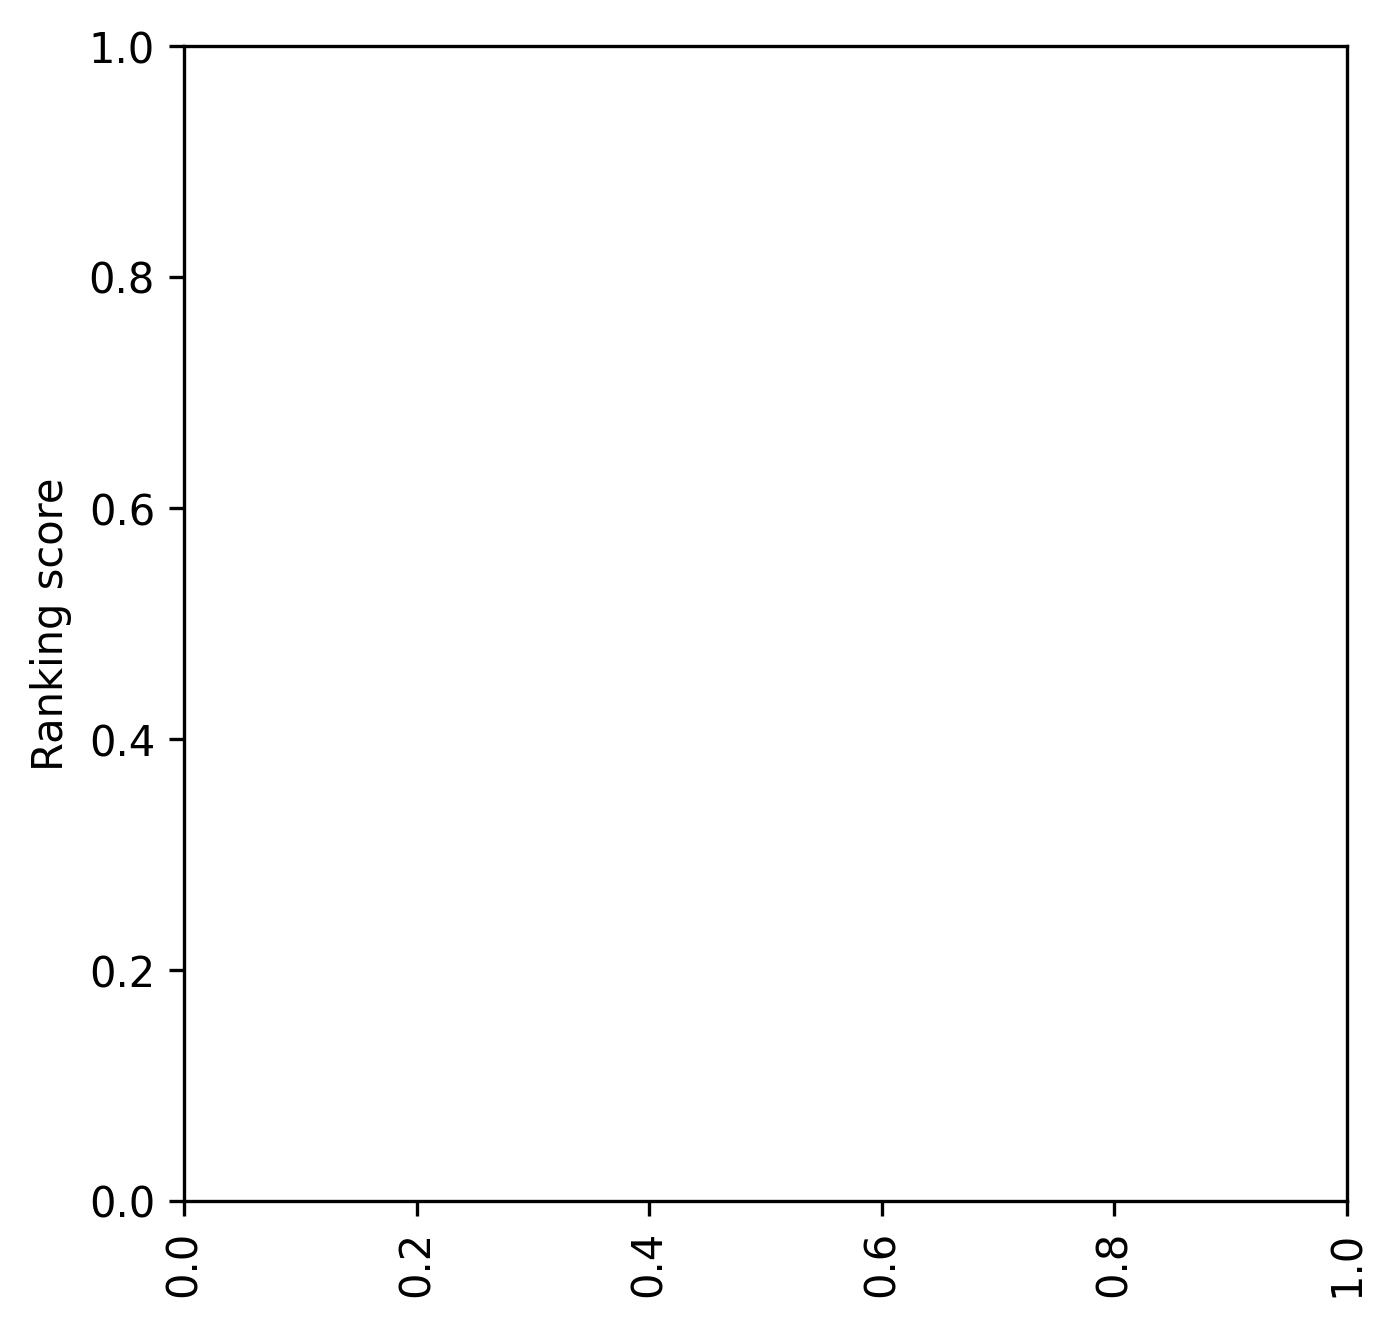

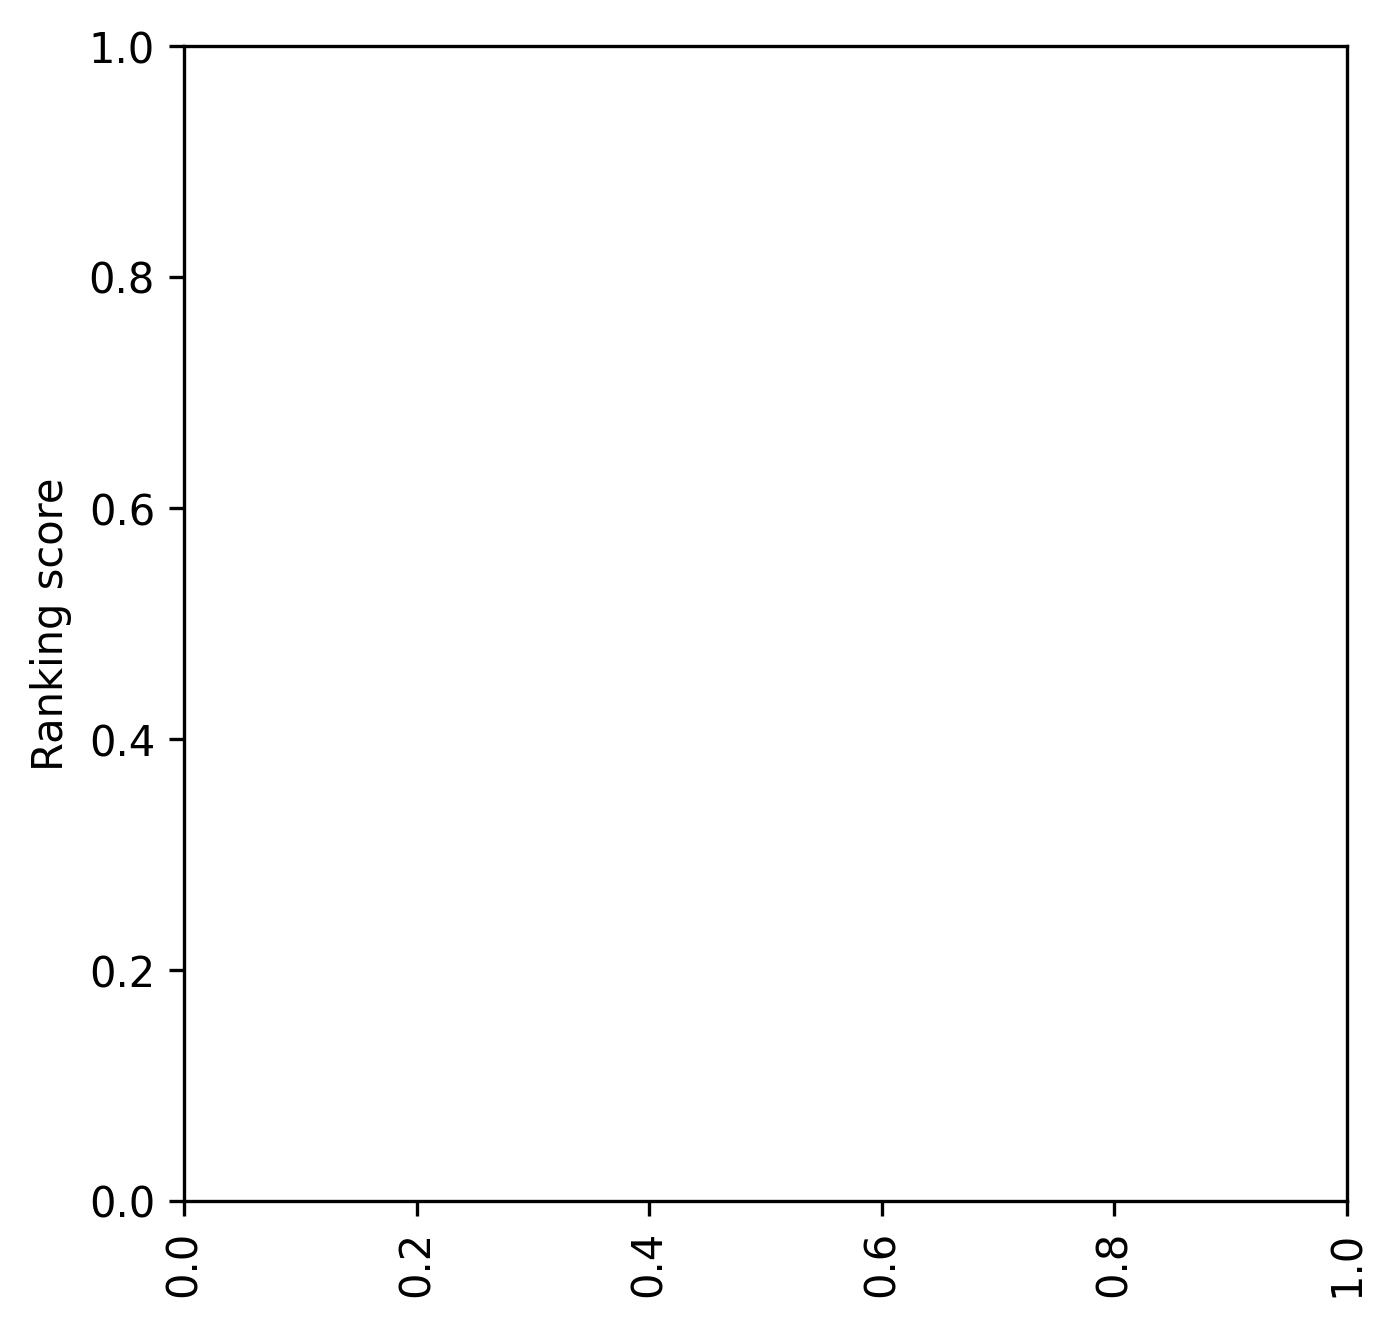

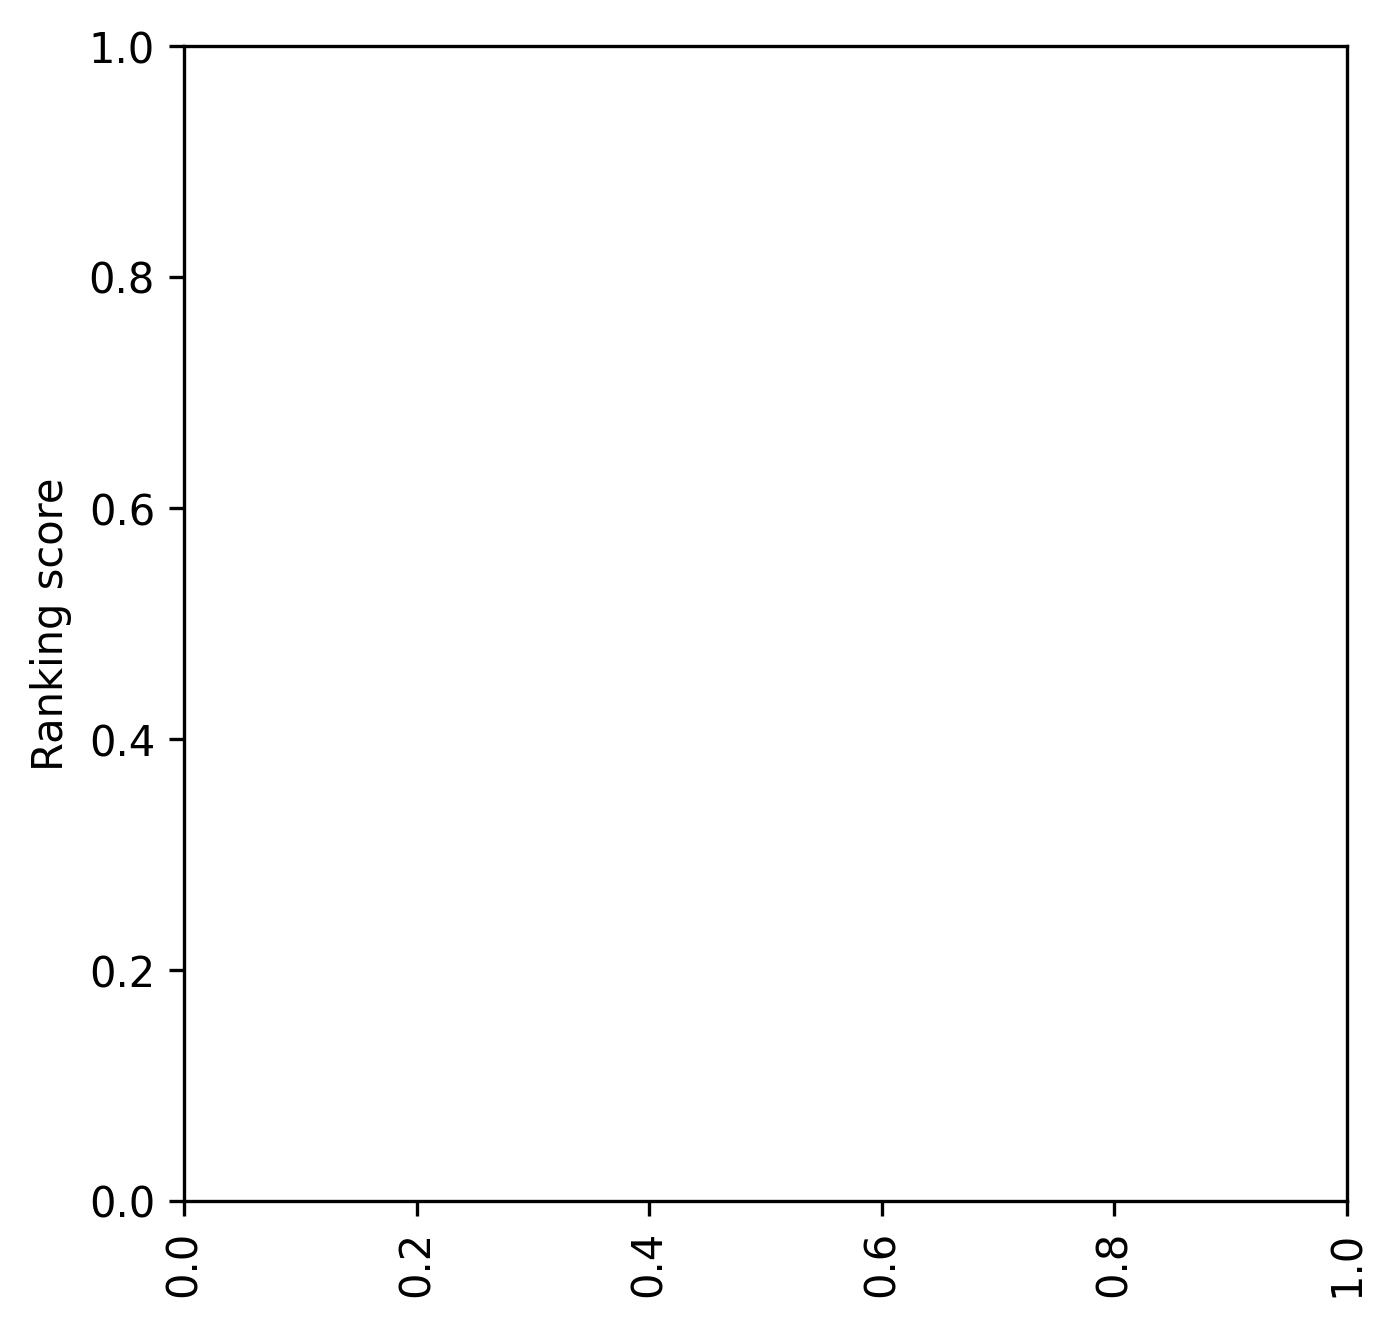

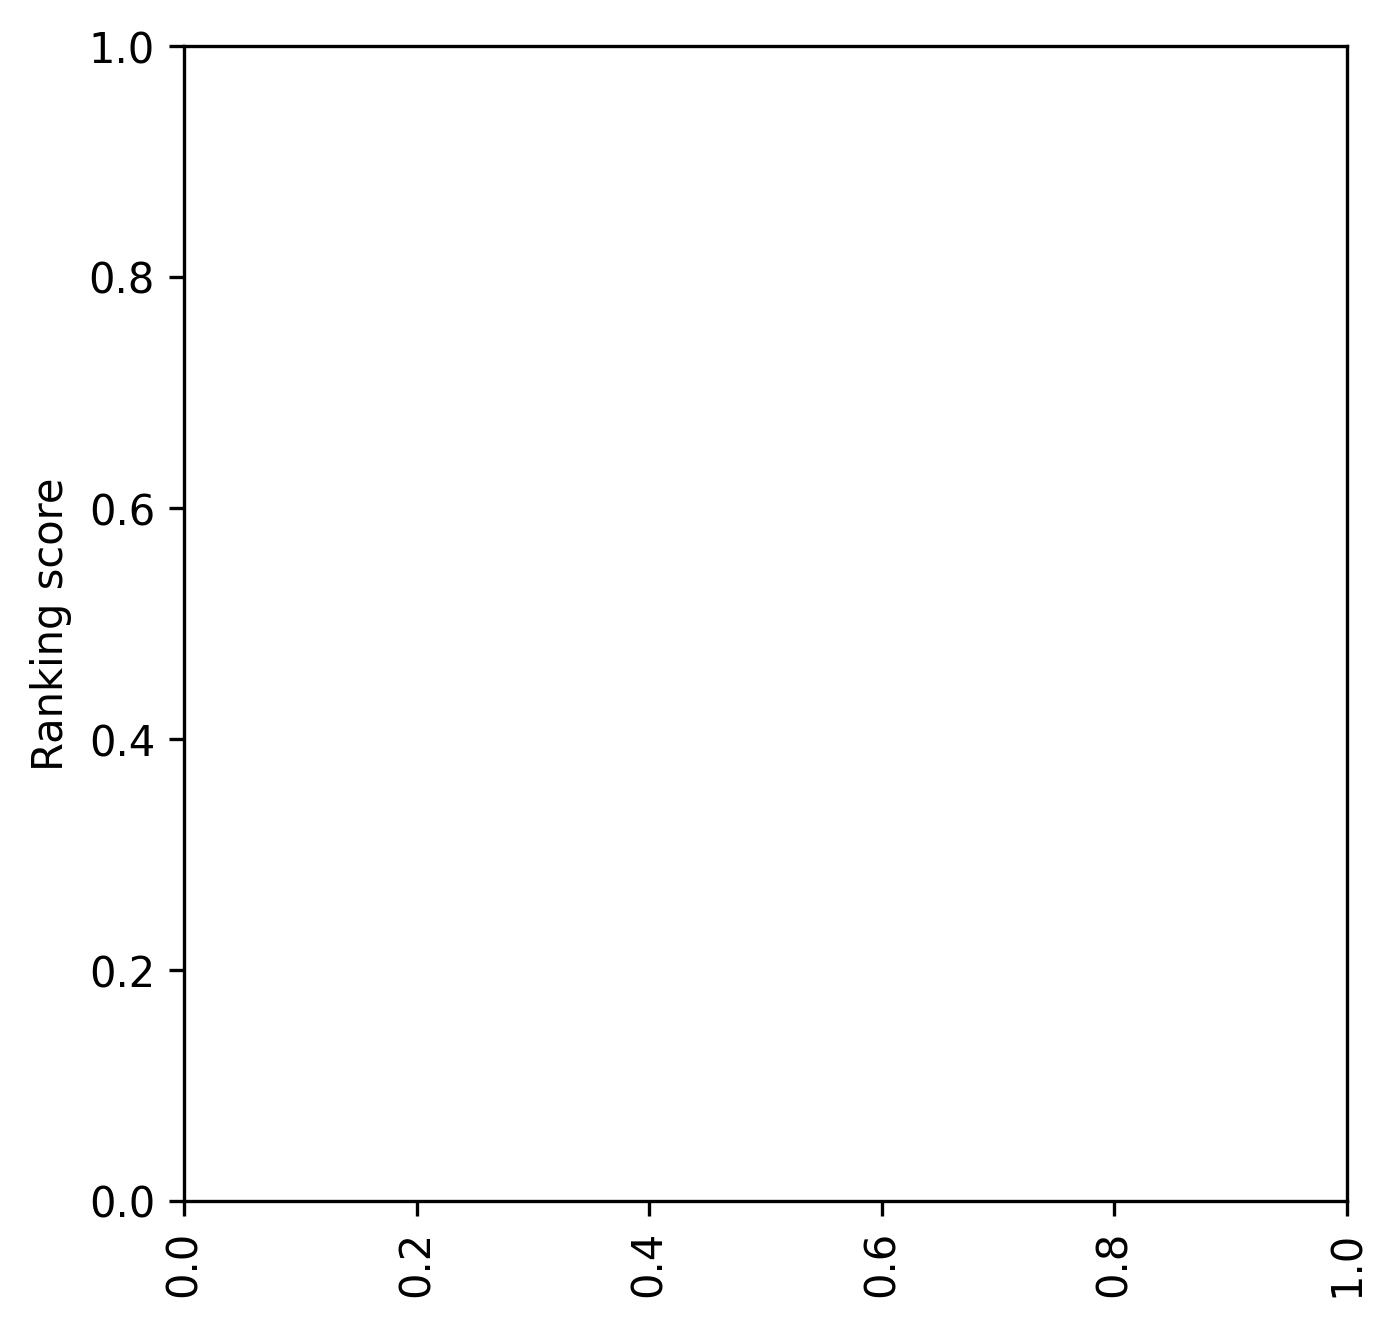

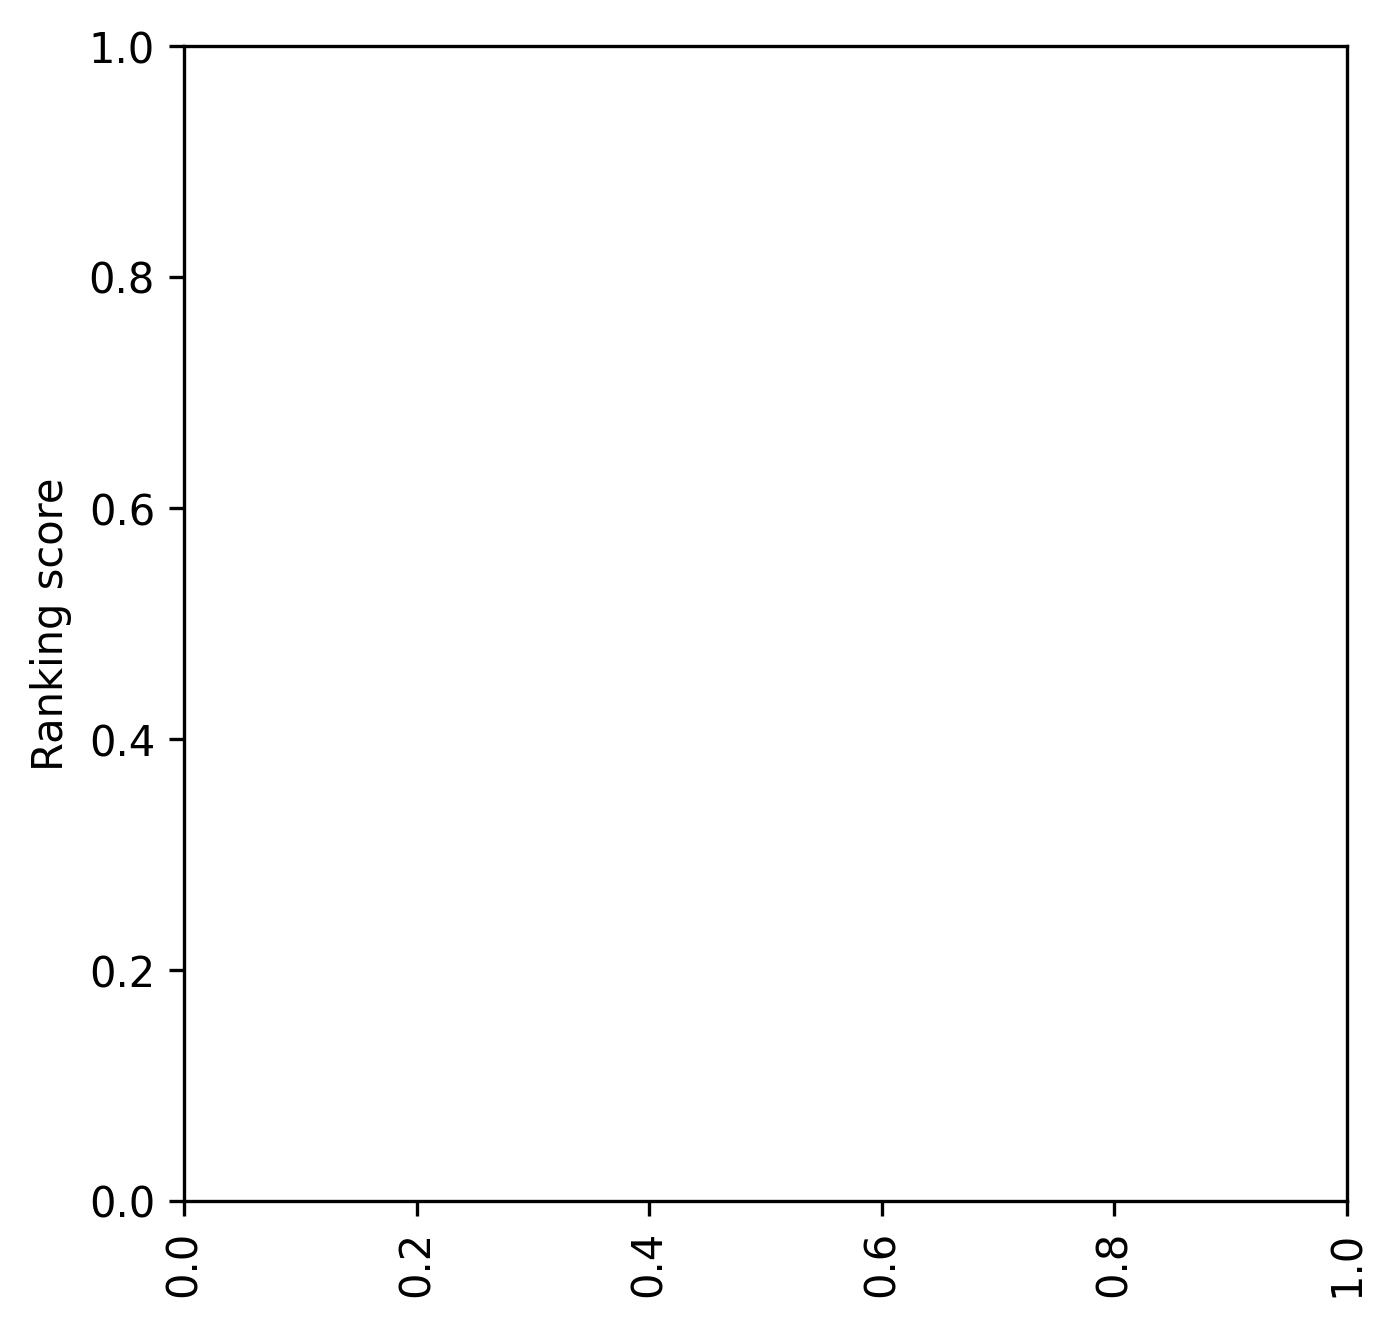

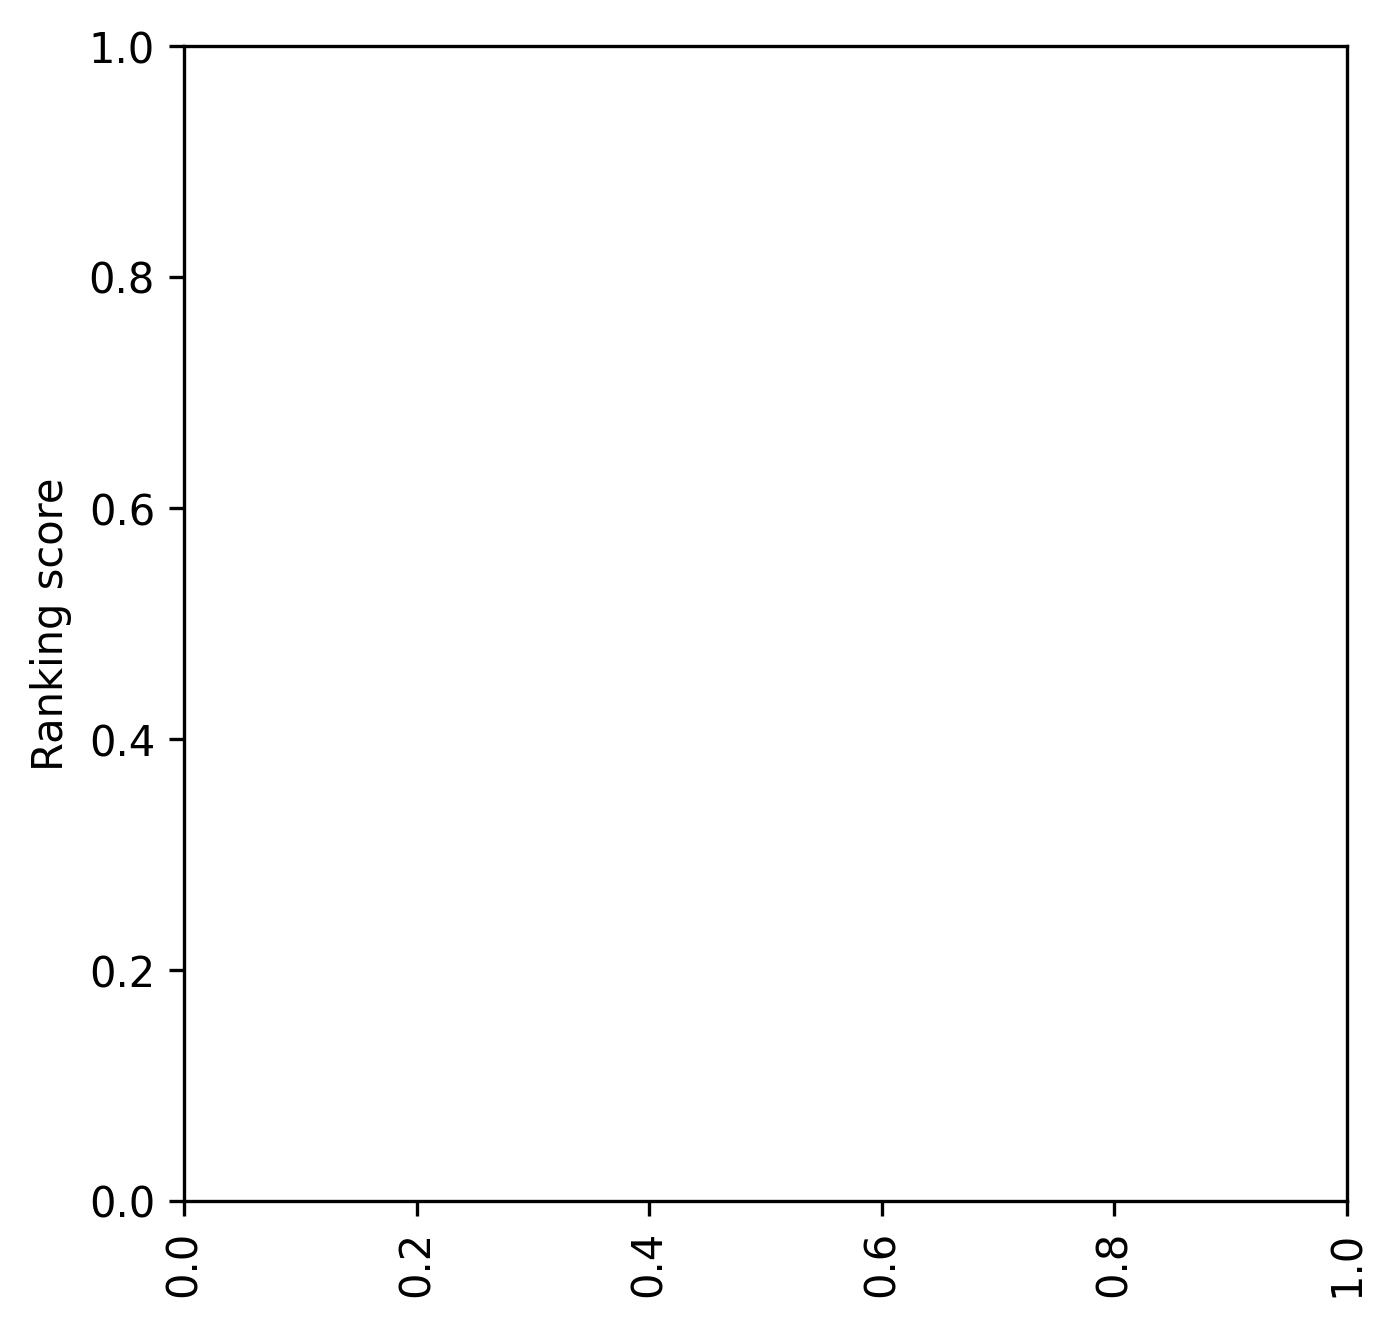

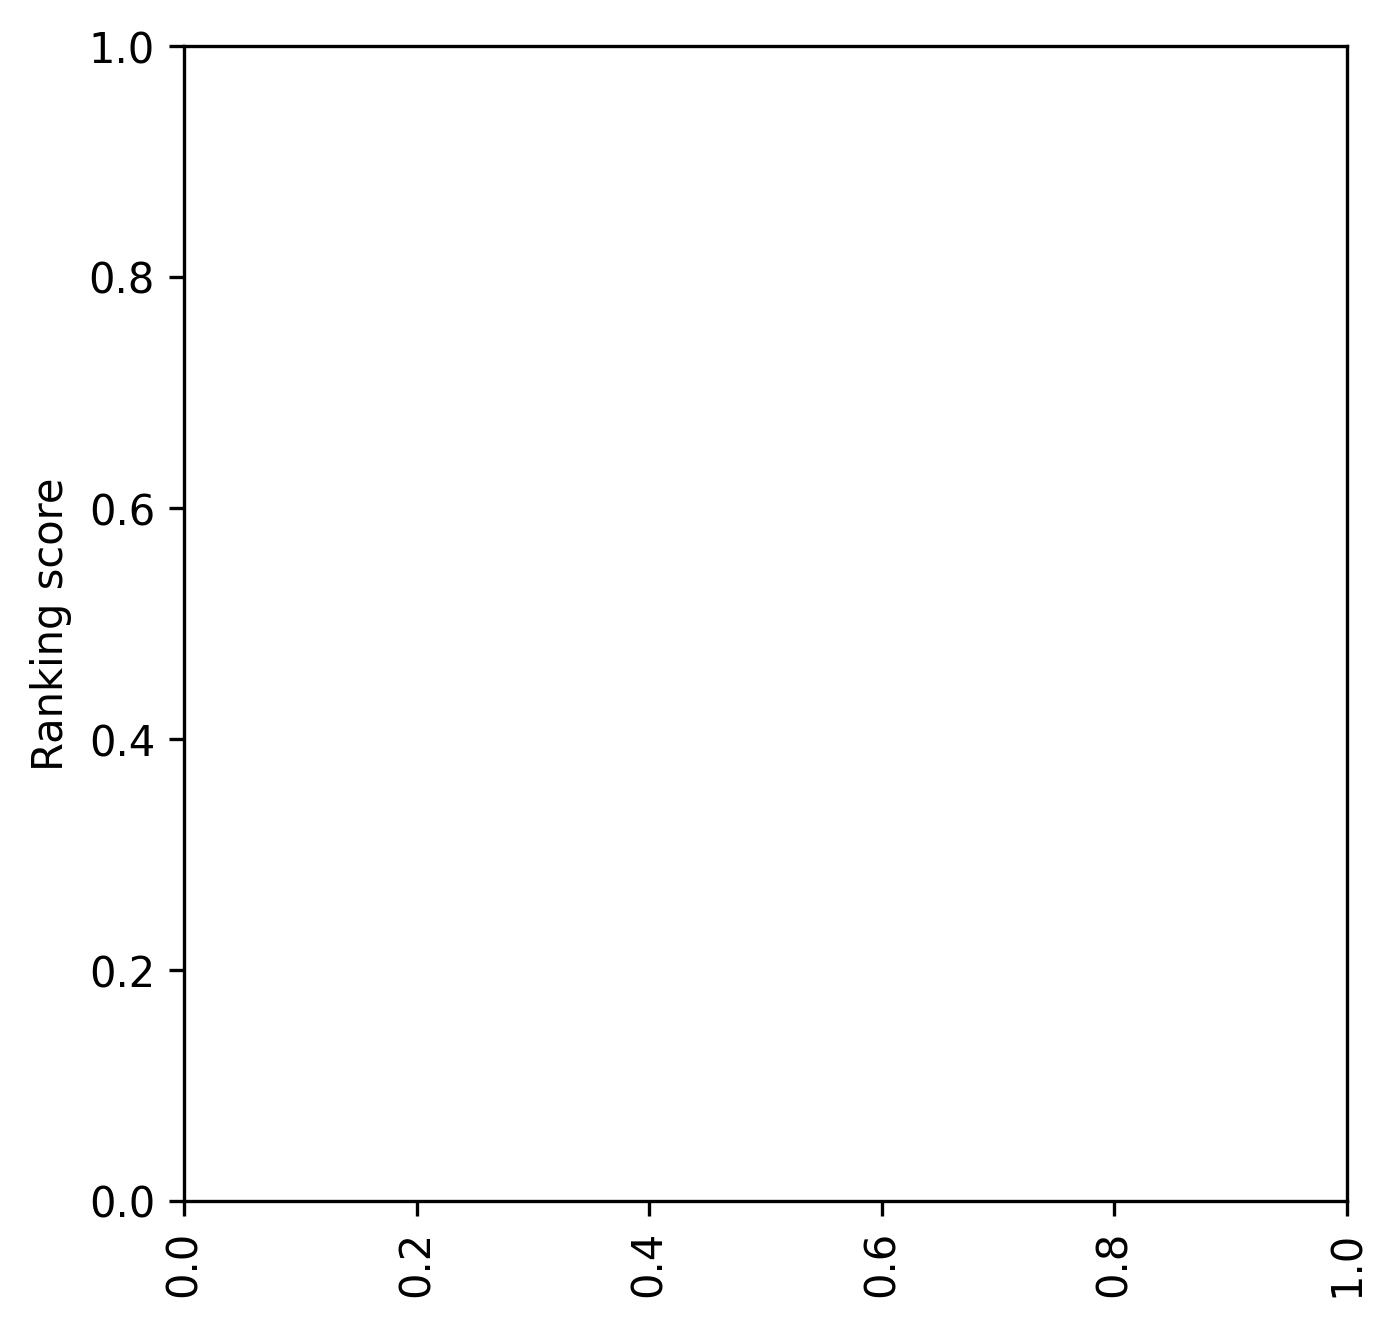

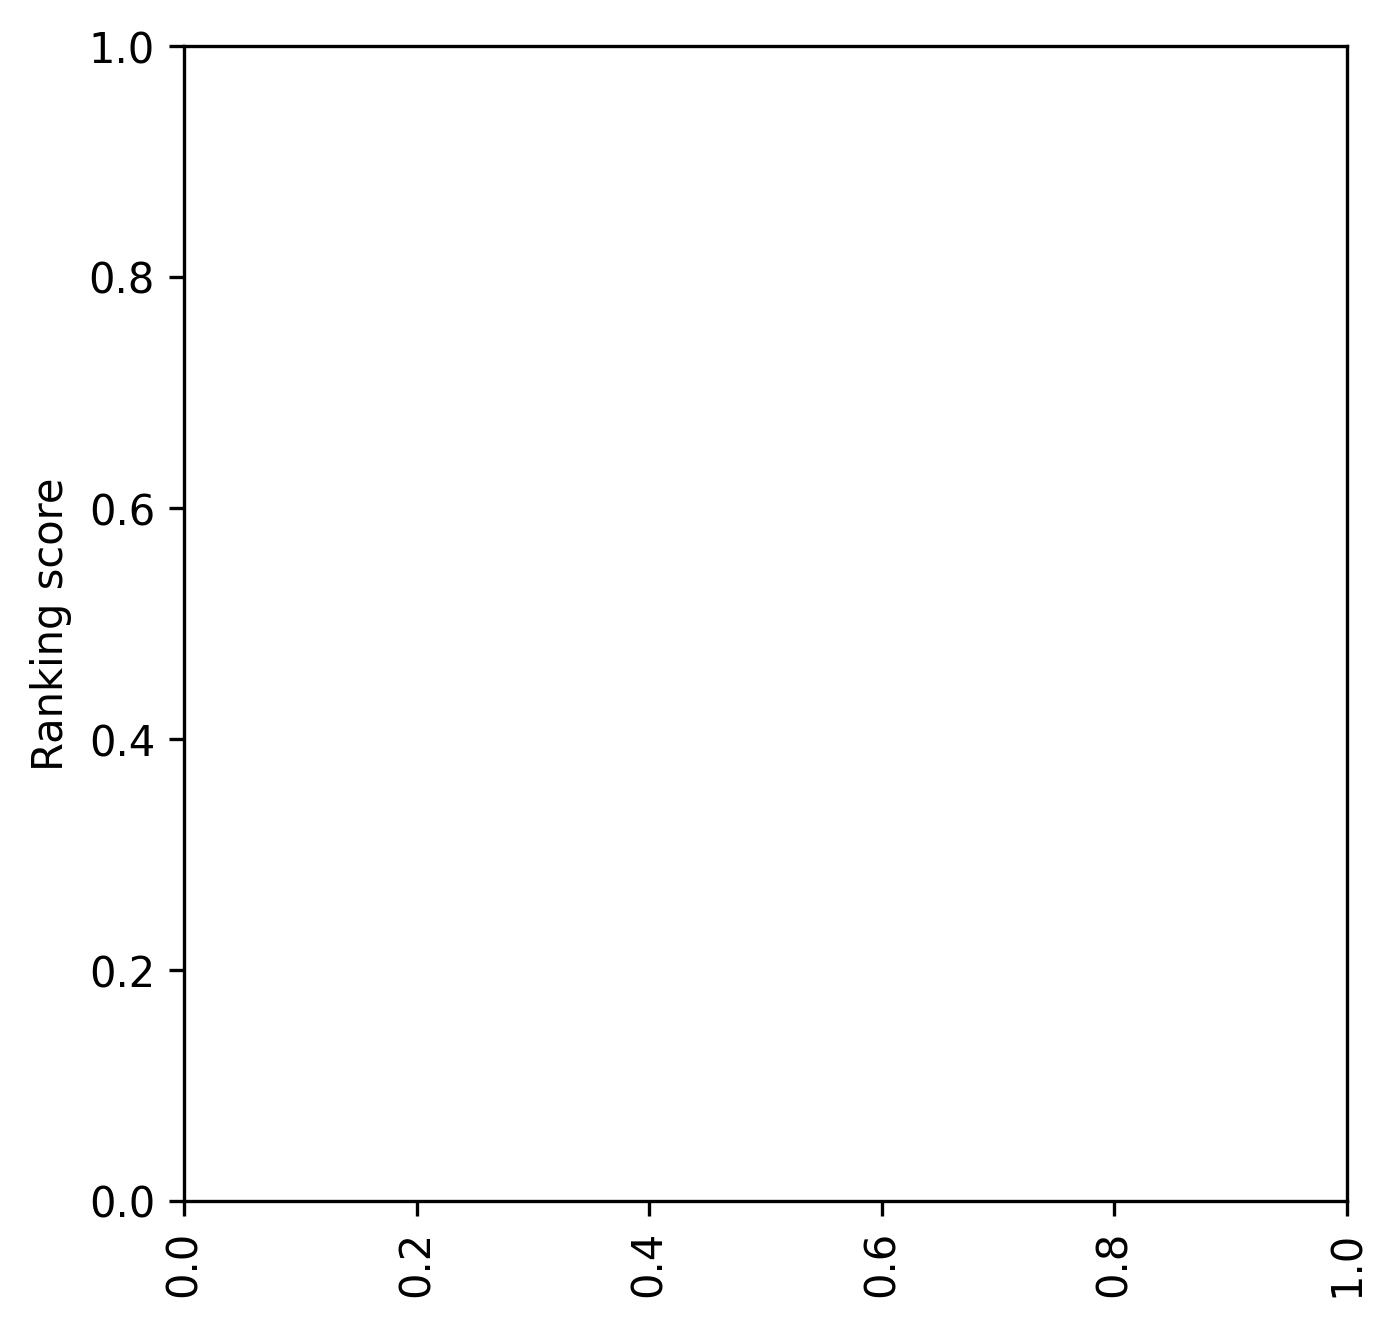

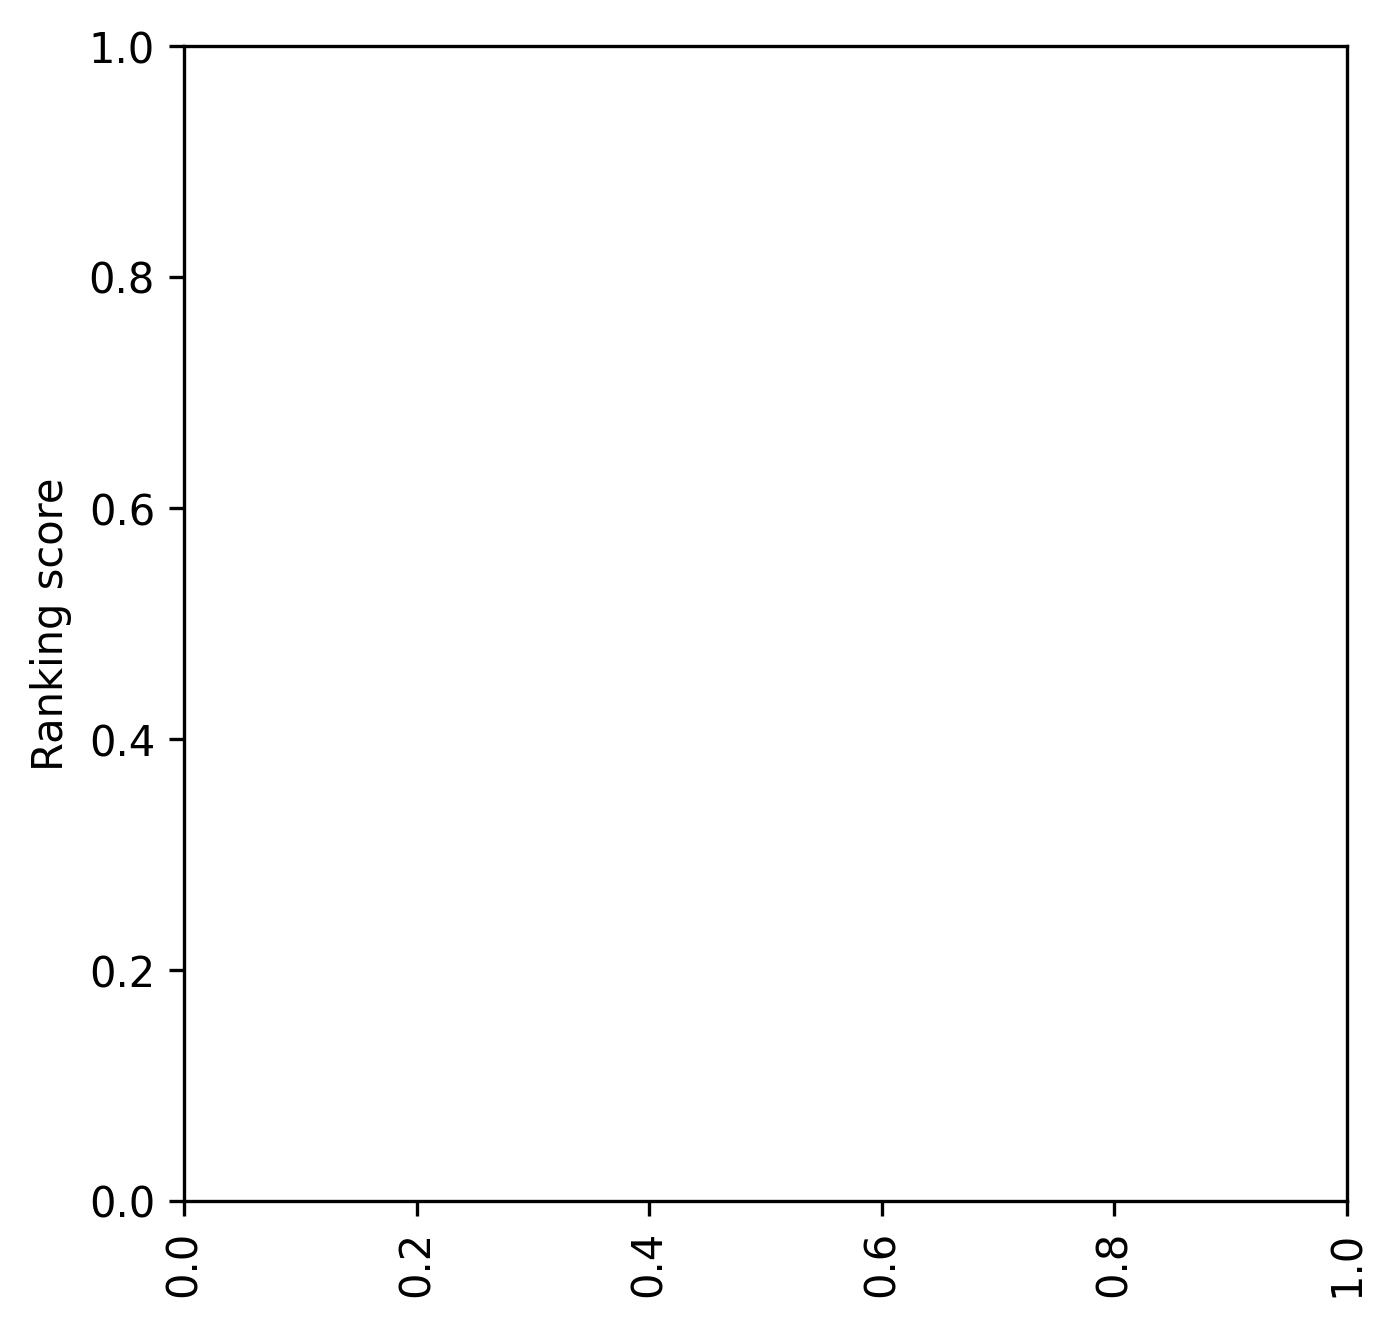

In [5]:
if not TCT_AVAILABLE or len(input_gene_curies) == 0:
    print("⚠️  Skipping - TCT not available or no genes normalized")
    pathfinder_all_results = {}
    pathfinder_all_paths = []
    pathfinder_errors = []
    pathfinder_time = 0
else:
    print("=" * 60)
    print("APPROACH 2: TCT.Path_finder() Direct Usage")
    print("=" * 60)
    
    print(f"\nCalling Path_finder for each gene → disease pair:")
    print(f"  Genes: {len(input_gene_curies)}")
    print(f"  Disease: {COVID19_CURIE}")
    print(f"  Intermediate categories: {', '.join([c.replace('biolink:', '') for c in INTERMEDIATE_CATEGORIES])}")
    
    # Store all results from Path_finder calls
    pathfinder_all_results = {}  # gene_curie -> Path_finder results
    pathfinder_all_paths = []    # All paths found across all genes
    pathfinder_errors = []
    
    start_time_pf = time.time()
    
    for i, gene_curie in enumerate(input_gene_curies):
        gene_symbol = normalized_genes_df[normalized_genes_df['curie'] == gene_curie]['original'].values[0]
        print(f"\n  [{i+1}/{len(input_gene_curies)}] {gene_symbol} ({gene_curie}) → {COVID19_CURIE}")
        
        try:
            # Call TCT.Path_finder directly
            # Path_finder internally uses NodeNormalizer which may not recognize all CURIEs
            pf_result = TCT.Path_finder(
                input_node1=gene_curie,
                input_node2=COVID19_CURIE,
                intermediate_categories=INTERMEDIATE_CATEGORIES,
                APInames=APInames,
                metaKG=metaKG,
                API_predicates=API_predicates,
                input_node1_category=['biolink:Gene'],
                input_node2_category=['biolink:Disease']
            )
            
            # Path_finder returns a tuple: (merged_df, input_node1_id, node1_info, input_node2_id, node2_info)
            # or similar structure depending on version
            if pf_result is not None:
                # Handle different return formats
                if isinstance(pf_result, tuple):
                    # Try to find the DataFrame in the tuple
                    paths_df = None
                    for item in pf_result:
                        if isinstance(item, pd.DataFrame) and len(item) > 0:
                            paths_df = item.copy()
                            break
                    
                    if paths_df is not None and len(paths_df) > 0:
                        paths_df['source_gene'] = gene_curie
                        paths_df['source_gene_symbol'] = gene_symbol
                        pathfinder_all_paths.append(paths_df)
                        print(f"       ✓ Found {len(paths_df)} paths")
                    else:
                        print(f"       - No paths in result tuple")
                        
                elif isinstance(pf_result, pd.DataFrame):
                    if len(pf_result) > 0:
                        pf_result = pf_result.copy()
                        pf_result['source_gene'] = gene_curie
                        pf_result['source_gene_symbol'] = gene_symbol
                        pathfinder_all_paths.append(pf_result)
                        print(f"       ✓ Found {len(pf_result)} paths")
                    else:
                        print(f"       - Empty DataFrame returned")
                else:
                    print(f"       - Unexpected return type: {type(pf_result)}")
            else:
                print(f"       - None returned")
                
            pathfinder_all_results[gene_curie] = pf_result
            
        except Exception as e:
            error_msg = str(e)
            # Truncate long error messages for display
            display_msg = error_msg[:80] + "..." if len(error_msg) > 80 else error_msg
            print(f"       ✗ Error: {display_msg}")
            pathfinder_errors.append((gene_curie, gene_symbol, error_msg))
            pathfinder_all_results[gene_curie] = None
    
    pathfinder_time = time.time() - start_time_pf
    
    # Combine all paths into single DataFrame
    if pathfinder_all_paths:
        pathfinder_combined_df = pd.concat(pathfinder_all_paths, ignore_index=True)
    else:
        pathfinder_combined_df = pd.DataFrame()
    
    print(f"\n{'=' * 60}")
    print(f"APPROACH 2 RESULTS (Path_finder)")
    print(f"{'=' * 60}")
    print(f"Genes queried: {len(input_gene_curies)}")
    print(f"Genes with paths: {len(pathfinder_all_paths)}")
    print(f"Total paths found: {len(pathfinder_combined_df)}")
    print(f"Errors: {len(pathfinder_errors)}")
    print(f"Execution time: {pathfinder_time:.1f}s")
    
    if len(pathfinder_errors) > 0:
        print(f"\nError details:")
        for gene_curie, gene_symbol, error in pathfinder_errors[:5]:  # Show first 5 errors
            print(f"  {gene_symbol}: {error[:60]}...")
    
    if len(pathfinder_combined_df) > 0:
        print(f"\nPath_finder results columns: {list(pathfinder_combined_df.columns)}")
        print(f"\nSample paths:")
        display(pathfinder_combined_df.head(5))

## 5. Result Comparison - Intermediates

In [6]:
def extract_nodes_from_results(result_dict: Dict) -> Tuple[Set[str], Set[str]]:
    """Extract unique subject and object CURIEs from TCT results."""
    subjects = set()
    objects = set()
    
    for k, v in result_dict.items():
        if isinstance(v, dict):
            subj = v.get('subject', '')
            obj = v.get('object', '')
            if subj:
                subjects.add(subj)
            if obj:
                objects.add(obj)
    
    return subjects, objects


def categorize_curie(curie: str) -> str:
    """Categorize a CURIE by its prefix."""
    if curie.startswith('NCBIGene:') or curie.startswith('HGNC:'):
        return 'Gene'
    elif curie.startswith('UniProtKB:') or curie.startswith('PR:'):
        return 'Protein'
    elif curie.startswith('CHEBI:') or curie.startswith('CHEMBL:'):
        return 'ChemicalEntity'
    elif curie.startswith('MONDO:') or curie.startswith('DOID:'):
        return 'Disease'
    elif curie.startswith('GO:'):
        return 'BiologicalProcess'
    else:
        return 'Other'


# Extract intermediates from Approach 1 (2-hop query)
print("=" * 60)
print("EXTRACTING INTERMEDIATES")
print("=" * 60)

if approach1_results:
    subj1, obj1 = extract_nodes_from_results(approach1_results)
    all_nodes_1 = subj1 | obj1
    
    # Intermediates = nodes that are NOT input genes and NOT disease
    intermediates_2hop = all_nodes_1 - set(input_gene_curies) - {COVID19_CURIE}
    
    print(f"\nApproach 1 (Custom 2-hop query):")
    print(f"  Total unique nodes: {len(all_nodes_1)}")
    print(f"  Intermediate nodes: {len(intermediates_2hop)}")
else:
    intermediates_2hop = set()
    print("\nApproach 1: No results")

# Extract intermediates from Approach 2 (Path_finder)
if 'pathfinder_combined_df' in dir() and len(pathfinder_combined_df) > 0:
    # Path_finder returns paths with intermediate nodes
    # Look for columns that might contain intermediate node info
    print(f"\nApproach 2 (Path_finder) - analyzing results...")
    print(f"  Columns available: {list(pathfinder_combined_df.columns)}")
    
    # Try to extract intermediates from Path_finder results
    # Common column names: 'intermediate', 'node', 'path_node', 'merged_node'
    intermediates_pathfinder = set()
    
    # Check for intermediate-related columns
    intermediate_cols = [col for col in pathfinder_combined_df.columns 
                        if 'intermediate' in col.lower() or 'node' in col.lower() or 'merged' in col.lower()]
    
    if intermediate_cols:
        for col in intermediate_cols:
            if col not in ['source_gene', 'source_gene_symbol']:
                values = pathfinder_combined_df[col].dropna().unique()
                for val in values:
                    if isinstance(val, str) and ':' in val:  # Looks like a CURIE
                        if val not in input_gene_curies and val != COVID19_CURIE:
                            intermediates_pathfinder.add(val)
        print(f"  Extracted from columns: {intermediate_cols}")
    else:
        # Fallback: try to find any CURIE-like values in the dataframe
        for col in pathfinder_combined_df.columns:
            if col not in ['source_gene', 'source_gene_symbol']:
                try:
                    values = pathfinder_combined_df[col].dropna().unique()
                    for val in values:
                        if isinstance(val, str) and ':' in val:
                            if val not in input_gene_curies and val != COVID19_CURIE:
                                intermediates_pathfinder.add(val)
                except:
                    pass
    
    print(f"\nApproach 2 (Path_finder):")
    print(f"  Total paths: {len(pathfinder_combined_df)}")
    print(f"  Unique intermediates extracted: {len(intermediates_pathfinder)}")
else:
    intermediates_pathfinder = set()
    print("\nApproach 2 (Path_finder): No results")

EXTRACTING INTERMEDIATES

Approach 1 (Custom 2-hop query):
  Total unique nodes: 442
  Intermediate nodes: 432

Approach 2 (Path_finder) - analyzing results...
  Columns available: ['output_node', 'Name', 'Num_of_primary_infores', 'type_of_nodes', 'unique_predicates', 'source_gene', 'source_gene_symbol']
  Extracted from columns: ['output_node', 'type_of_nodes']

Approach 2 (Path_finder):
  Total paths: 2
  Unique intermediates extracted: 1


In [7]:
# Compare intermediates between approaches
print("=" * 60)
print("INTERMEDIATE NODE COMPARISON")
print("=" * 60)

# Calculate overlap
only_2hop = intermediates_2hop - intermediates_pathfinder
only_pathfinder = intermediates_pathfinder - intermediates_2hop
shared = intermediates_2hop & intermediates_pathfinder

print(f"\nOverlap Analysis:")
print(f"  Only in custom 2-hop approach: {len(only_2hop)}")
print(f"  Only in Path_finder: {len(only_pathfinder)}")
print(f"  Shared between both: {len(shared)}")

# Coverage comparison
if len(intermediates_2hop) > 0 or len(intermediates_pathfinder) > 0:
    total_unique = len(intermediates_2hop | intermediates_pathfinder)
    coverage_2hop = len(intermediates_2hop) / total_unique * 100 if total_unique > 0 else 0
    coverage_pathfinder = len(intermediates_pathfinder) / total_unique * 100 if total_unique > 0 else 0
    
    print(f"\nCoverage (% of total unique intermediates):")
    print(f"  Custom 2-hop: {coverage_2hop:.1f}% ({len(intermediates_2hop)}/{total_unique})")
    print(f"  Path_finder: {coverage_pathfinder:.1f}% ({len(intermediates_pathfinder)}/{total_unique})")

# Categorize intermediates by type
print(f"\nIntermediate Categories:")

def count_by_category(nodes: Set[str]) -> Dict[str, int]:
    counts = {}
    for node in nodes:
        cat = categorize_curie(node)
        counts[cat] = counts.get(cat, 0) + 1
    return counts

categories_2hop = count_by_category(intermediates_2hop)
categories_pathfinder = count_by_category(intermediates_pathfinder)

all_categories = sorted(set(categories_2hop.keys()) | set(categories_pathfinder.keys()))

category_df = pd.DataFrame({
    'Category': all_categories,
    'Custom 2-hop': [categories_2hop.get(c, 0) for c in all_categories],
    'Path_finder': [categories_pathfinder.get(c, 0) for c in all_categories]
})

display(category_df)

# Show some examples of unique intermediates
if len(only_2hop) > 0:
    print(f"\nSample intermediates unique to 2-hop (first 5):")
    for node in list(only_2hop)[:5]:
        print(f"  {node} ({categorize_curie(node)})")

if len(only_pathfinder) > 0:
    print(f"\nSample intermediates unique to Path_finder (first 5):")
    for node in list(only_pathfinder)[:5]:
        print(f"  {node} ({categorize_curie(node)})")

INTERMEDIATE NODE COMPARISON

Overlap Analysis:
  Only in custom 2-hop approach: 432
  Only in Path_finder: 1
  Shared between both: 0

Coverage (% of total unique intermediates):
  Custom 2-hop: 99.8% (432/433)
  Path_finder: 0.2% (1/433)

Intermediate Categories:


,Category,Custom 2-hop,Path_finder
0,ChemicalEntity,366,0
1,Disease,1,0
2,Gene,33,1
3,Other,32,0



Sample intermediates unique to 2-hop (first 5):
  NCBIGene:213 (Gene)
  CHEBI:4903 (ChemicalEntity)
  CHEBI:66910 (ChemicalEntity)
  CHEBI:4672 (ChemicalEntity)
  CHEBI:3749 (ChemicalEntity)

Sample intermediates unique to Path_finder (first 5):
  NCBIGene:3620 (Gene)


## 6. Result Comparison - Edges

In [8]:
def extract_edges_as_tuples(result_dict: Dict) -> Set[Tuple[str, str, str]]:
    """Extract unique (subject, predicate, object) tuples from results."""
    edges = set()
    for k, v in result_dict.items():
        if isinstance(v, dict):
            subj = v.get('subject', '')
            pred = v.get('predicate', '')
            obj = v.get('object', '')
            if subj and pred and obj:
                edges.add((subj, pred, obj))
    return edges


def count_predicates(edges: Set[Tuple[str, str, str]]) -> Dict[str, int]:
    """Count occurrences of each predicate."""
    counts = {}
    for _, pred, _ in edges:
        pred_short = pred.replace('biolink:', '')
        counts[pred_short] = counts.get(pred_short, 0) + 1
    return counts


print("=" * 60)
print("EDGE COMPARISON")
print("=" * 60)

# Extract edges from Approach 1 (custom 2-hop)
edges_2hop = extract_edges_as_tuples(approach1_results) if approach1_results else set()

print(f"\nCustom 2-hop approach: {len(edges_2hop)} unique edges")

# For Path_finder, we need to count paths/edges differently
# Path_finder returns ranked paths, not raw edges
if 'pathfinder_combined_df' in dir() and len(pathfinder_combined_df) > 0:
    pathfinder_path_count = len(pathfinder_combined_df)
    print(f"Path_finder approach: {pathfinder_path_count} paths found")
    
    # Try to count unique paths (if there's a path identifier column)
    if 'source_gene' in pathfinder_combined_df.columns:
        genes_with_paths = pathfinder_combined_df['source_gene'].nunique()
        print(f"  Genes with paths: {genes_with_paths}/{len(input_gene_curies)}")
else:
    pathfinder_path_count = 0
    print(f"Path_finder approach: 0 paths found")

# Predicate distribution from 2-hop results
if len(edges_2hop) > 0:
    print(f"\nTop predicates in custom 2-hop results:")
    pred_counts_2hop = count_predicates(edges_2hop)
    for pred, count in sorted(pred_counts_2hop.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {pred}: {count}")

EDGE COMPARISON

Custom 2-hop approach: 1369 unique edges
Path_finder approach: 2 paths found
  Genes with paths: 1/10

Top predicates in custom 2-hop results:
  affects: 643
  treats_or_applied_or_studied_to_treat: 379
  has_adverse_event: 105
  coexpressed_with: 84
  contributes_to: 48
  regulates: 28
  genetically_associated_with: 27
  directly_physically_interacts_with: 27
  has_part: 9
  physically_interacts_with: 8


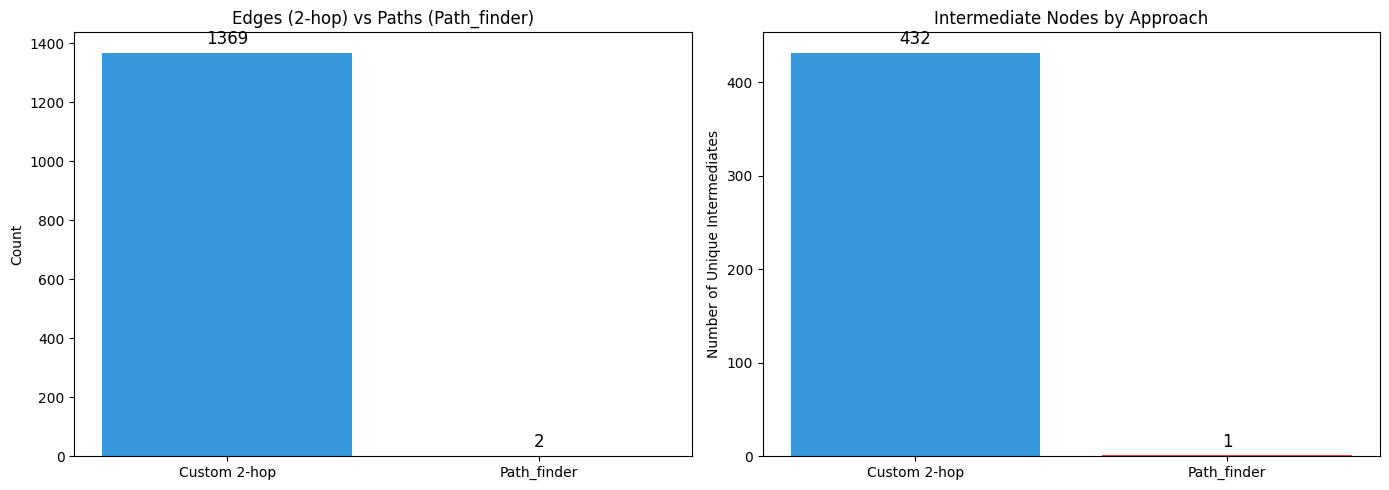

In [9]:
# Bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Edge/path counts
approaches = ['Custom 2-hop', 'Path_finder']
edge_counts = [len(edges_2hop), pathfinder_path_count if 'pathfinder_path_count' in dir() else 0]

axes[0].bar(approaches, edge_counts, color=['#3498db', '#e74c3c'])
axes[0].set_ylabel('Count')
axes[0].set_title('Edges (2-hop) vs Paths (Path_finder)')
for i, count in enumerate(edge_counts):
    axes[0].text(i, count + max(edge_counts)*0.02 if max(edge_counts) > 0 else 1, str(count), ha='center', fontsize=12)

# Right: Intermediate counts
intermediate_counts = [len(intermediates_2hop), len(intermediates_pathfinder)]

axes[1].bar(approaches, intermediate_counts, color=['#3498db', '#e74c3c'])
axes[1].set_ylabel('Number of Unique Intermediates')
axes[1].set_title('Intermediate Nodes by Approach')
for i, count in enumerate(intermediate_counts):
    axes[1].text(i, count + max(intermediate_counts)*0.02 if max(intermediate_counts) > 0 else 1, str(count), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

## 7. API Success Analysis

In [10]:
print("=" * 60)
print("API/EXECUTION ANALYSIS")
print("=" * 60)

print(f"\nApproach 1 (Custom 2-hop query):")
print(f"  APIs queried: {len(selected_APIs_2hop) if 'selected_APIs_2hop' in dir() else 'N/A'}")
print(f"  Results returned: {len(approach1_results)} edges")
print(f"  Execution time: {approach1_time:.1f}s" if 'approach1_time' in dir() else "  Execution time: N/A")

print(f"\nApproach 2 (Path_finder):")
print(f"  Gene-disease pairs queried: {len(input_gene_curies)}")
print(f"  Genes with paths: {len(pathfinder_all_paths)}")
print(f"  Total paths found: {len(pathfinder_combined_df) if 'pathfinder_combined_df' in dir() else 0}")
print(f"  Errors: {len(pathfinder_errors) if 'pathfinder_errors' in dir() else 0}")
print(f"  Execution time: {pathfinder_time:.1f}s" if 'pathfinder_time' in dir() else "  Execution time: N/A")

# Key difference explanation
print(f"\n{'=' * 60}")
print("KEY DIFFERENCES")
print("=" * 60)
print("""
1. Query Strategy:
   - Custom 2-hop: Single TRAPI query with all genes at once
   - Path_finder: Separate query per gene-disease pair

2. Result Format:
   - Custom 2-hop: Returns raw edges (subject, predicate, object)
   - Path_finder: Returns ranked paths with intermediate nodes

3. API Usage:
   - Custom 2-hop: Sends one complex 2-hop query to APIs
   - Path_finder: Uses two 1-hop queries internally, then merges
""")

API/EXECUTION ANALYSIS

Approach 1 (Custom 2-hop query):
  APIs queried: 17
  Results returned: 1575 edges
  Execution time: 301.0s

Approach 2 (Path_finder):
  Gene-disease pairs queried: 10
  Genes with paths: 1
  Total paths found: 2
  Errors: 1
  Execution time: 1358.3s

KEY DIFFERENCES

1. Query Strategy:
   - Custom 2-hop: Single TRAPI query with all genes at once
   - Path_finder: Separate query per gene-disease pair

2. Result Format:
   - Custom 2-hop: Returns raw edges (subject, predicate, object)
   - Path_finder: Returns ranked paths with intermediate nodes

3. API Usage:
   - Custom 2-hop: Sends one complex 2-hop query to APIs
   - Path_finder: Uses two 1-hop queries internally, then merges



## 8. Summary & Conclusions

In [11]:
print("=" * 60)
print("SUMMARY: PATHFINDER COMPARISON")
print("=" * 60)

# Build summary table
summary_data = {
    'Metric': [
        'Total Edges/Paths',
        'Unique Intermediates',
        'Intermediates (Gene)',
        'Intermediates (Protein)',
        'Intermediates (Chemical)',
        'Execution Time (s)'
    ],
    'Custom 2-hop': [
        len(edges_2hop),
        len(intermediates_2hop),
        categories_2hop.get('Gene', 0),
        categories_2hop.get('Protein', 0),
        categories_2hop.get('ChemicalEntity', 0),
        f"{approach1_time:.1f}" if 'approach1_time' in dir() else 'N/A'
    ],
    'Path_finder': [
        pathfinder_path_count if 'pathfinder_path_count' in dir() else 0,
        len(intermediates_pathfinder),
        categories_pathfinder.get('Gene', 0),
        categories_pathfinder.get('Protein', 0),
        categories_pathfinder.get('ChemicalEntity', 0),
        f"{pathfinder_time:.1f}" if 'pathfinder_time' in dir() else 'N/A'
    ]
}

summary_df = pd.DataFrame(summary_data)
display(summary_df)

# Conclusions
print(f"\n{'=' * 60}")
print("KEY FINDINGS")
print("=" * 60)

if len(intermediates_2hop) > 0 or len(intermediates_pathfinder) > 0:
    int_diff = len(intermediates_pathfinder) - len(intermediates_2hop)
    if int_diff > 0:
        print(f"\n1. Path_finder found {int_diff} MORE unique intermediates.")
    elif int_diff < 0:
        print(f"\n1. Custom 2-hop found {abs(int_diff)} MORE unique intermediates.")
    else:
        print(f"\n1. Both approaches found the same number of intermediates.")
    
    overlap_pct = len(shared) / max(len(intermediates_2hop), len(intermediates_pathfinder)) * 100 if max(len(intermediates_2hop), len(intermediates_pathfinder)) > 0 else 0
    print(f"\n2. Overlap: {len(shared)} intermediates shared ({overlap_pct:.1f}% of larger set)")
    
    print(f"\n3. Unique to custom 2-hop: {len(only_2hop)} intermediates")
    print(f"   Unique to Path_finder: {len(only_pathfinder)} intermediates")
    
    # Timing comparison
    if 'approach1_time' in dir() and 'pathfinder_time' in dir():
        if pathfinder_time > approach1_time:
            print(f"\n4. Custom 2-hop was {pathfinder_time/approach1_time:.1f}x faster")
        else:
            print(f"\n4. Path_finder was {approach1_time/pathfinder_time:.1f}x faster")
else:
    print("\nInsufficient data for comparison.")

print(f"\n{'=' * 60}")

SUMMARY: PATHFINDER COMPARISON


,Metric,Custom 2-hop,Path_finder
0,Total Edges/Paths,1369,2
1,Unique Intermediates,432,1
2,Intermediates (Gene),33,1
3,Intermediates (Protein),0,0
4,Intermediates (Chemical),366,0
5,Execution Time (s),301.0,1358.3



KEY FINDINGS

1. Custom 2-hop found 431 MORE unique intermediates.

2. Overlap: 0 intermediates shared (0.0% of larger set)

3. Unique to custom 2-hop: 432 intermediates
   Unique to Path_finder: 1 intermediates

4. Custom 2-hop was 4.5x faster



In [12]:
# Save comparison results
output_file = DATA_DIR / "comparison" / f"pathfinder_comparison_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"

comparison_results = {
    'timestamp': datetime.now().isoformat(),
    'test_dataset': 'COVID-19 genes',
    'disease_curie': COVID19_CURIE,
    'input_genes': COVID_GENES,
    'approach_1_custom_2hop': {
        'edges': len(edges_2hop),
        'intermediates': len(intermediates_2hop),
        'apis_queried': len(selected_APIs_2hop) if 'selected_APIs_2hop' in dir() else None,
        'execution_time_s': approach1_time if 'approach1_time' in dir() else None
    },
    'approach_2_pathfinder': {
        'paths': pathfinder_path_count if 'pathfinder_path_count' in dir() else 0,
        'intermediates': len(intermediates_pathfinder),
        'genes_with_paths': len(pathfinder_all_paths) if 'pathfinder_all_paths' in dir() else 0,
        'errors': len(pathfinder_errors) if 'pathfinder_errors' in dir() else 0,
        'execution_time_s': pathfinder_time if 'pathfinder_time' in dir() else None
    },
    'overlap': {
        'shared_intermediates': len(shared),
        'only_2hop': len(only_2hop),
        'only_pathfinder': len(only_pathfinder)
    }
}

with open(output_file, 'w') as f:
    json.dump(comparison_results, f, indent=2)

print(f"✓ Results saved to: {output_file}")

✓ Results saved to: data/comparison/pathfinder_comparison_20260109_150328.json
